# Comparing statistics of NO2 pollution for European cities

In [1]:
from pathlib import Path
import getpass

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.plot
from rasterio import features

from sentinelhub import (
    SHConfig,
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubStatisticalDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    SentinelHubStatistical,
    Geometry,
    parse_time,
)


# Measuring NO2 concentrations

Nitrogen dioxide is primarily produced by the burning of fossil fuels. High concentration of Nitrogen dioxide are widely known to cause inlammation of the airways, with long-term exposure leading to respiratory problems such as asthma and bronchitis. Areas with high-density road networks close to large populations are most at risk of over-exposure. For thise with pre-existing conditions, along with children and the elderly, this risk is more pronounced. Therefore, regular monitoring of Nitrogen dioxide concentrations is essential for avoiding health risks and keepint track of pollution.
The main objective of the Copernicus Sentinel-5P mission is to perform atmospheric measurements with high spatio-temporal resolution, to be used for air quality, ozone & UV radiation, and climate monitoring & forecasting.

Sources: https://www.aeroqual.com/measurements/nitrogen-dioxide, 
https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-5p

The Copernicus Browser and the connected APIs offer you new and more efficient ways to access and analyse data. 

## Outline

This notebook analyses air pollution in Europe using the TROPOMI sensor on the Sentinel 5P satellite. This notebook aims to provide data to answer the following questions:

- What is the spatial distribution of NO2 concentration in Europe
- How does the NO2 concentration vary over a year
- Which European capitals are most affected by NO2 emissions

## Used tools and features

To carry out these analyses we will cover a few different concepts and features available on the Copernicus Dataspace Ecosystem:

- Downloading of Raw data using custom resolutions and bounding boxes
- Calculation of monthly mosaics on the fly in the cloud
- Direct access to timeseries data for geometries through the statistical API

### Credentials

Credentials for Sentinel Hub services (`client_id` & `client_secret`) can be obtained in your [Dashboard](https://shapps.dataspace.copernicus.eu/dashboard/#/). In the User Settings you can create a new OAuth Client to generate these credentials. For more detailed instructions, visit the relevant [documentation page](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Overview/Authentication.html).

Now that you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions on how to configure your Sentinel Hub Python package can be found [here](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). Using these instructions you can create a profile specific to using the package for accessing Copernicus Data Space Ecosystem data collections. This is useful as changes to the the config class are usually only temporary in your notebook and by saving the configuration to your profile you won't need to generate new credentials or overwrite/change the default profile each time you rerun or write a new Jupyter Notebook. 

If you are a first time user of the Sentinel Hub Python package for Copernicus Data Space Ecosystem, you should create a profile specific to the Copernicus Data Space Ecosystem. You can do this in the following cell:

In [ ]:
# Only run this cell if you have not created a configuration.

config = SHConfig()
# config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
# config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
# config.save("cdse")

However, if you have already configured a profile in Sentinel Hub Python for the Copernicus Data Space Ecosystem, then you can run the below cell entering the profile name as a string replacing `profile_name`.

In [ ]:
# config = SHConfig("profile_name")

### Analysing Spatial Distribution

Let's first get an overview of our study area, which is most of mainland Europe. To get this overview we first define an evalscript. An evalscript is a piece of javascript code which specifies how each pixel should be handled. For the first one we just define the input band that we want to look at, which is `NO2` and return that band immediately, without carrying out any more calculations before the data is returned to us.

For more information on evalscripts have a look at the [documentation](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript.html).

```js
//VERSION=3
function setup() {
   return {
    input: ["NO2"], // This specifies the bands that are looked at
    output: { 
      bands: 1,
      // This specifies in which data type the values will be returned
      sampleType: "FLOAT32"
    },
    // Will make a simple mosaic, taking the most recent tiles to fill the bounding box
    mosaicking: "SIMPLE"
  };
}

function evaluatePixel(samples) {
    // Here we could do more calculations which are applied to each pixel, 
    // but for now let's just return the value 
   return [samples.NO2] 
}
```

In [6]:
# We also need to define the evalscript as a Python variable
evalscript_raw = """
//VERSION=3
function setup() {
   return {
    input: ["NO2"], // This specifies the bands that are looked at
    output: { 
      bands: 1,
      // This specifies in which data type the values will be returned
      sampleType: "FLOAT32"
    },
    // Will make a simple mosaic, taking the most recent tiles to fill the bounding box
    mosaicking: "SIMPLE"
  };
}

function evaluatePixel(samples) {
    // Here we could do more calculations which are applied to each pixel, 
    // but for now let's just return the value 
   return [samples.NO2] 
}
"""

With the evalscript we can now make a request for data.

The request will take care of a lot of things for us. It will return our the data in our specified resolution and bounding box, for our specified time range and it will automatically mosaic multiple tiles together to fill the entire bounding box.

In [10]:
bbox_europe = BBox([-12.30, 34.59, 32.52, 63.15], crs=CRS.WGS84).transform(CRS(3857))
# This is defining the data we will use.
# You can list all available data collections with `DataCollection.get_available_collections()`.
data_5p = DataCollection.SENTINEL5P.define_from("5p", service_url=config.sh_base_url)

request_raw = SentinelHubRequest(
    evalscript=evalscript_raw,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=data_5p,
            time_interval=("2023-01-01", "2023-05-26"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox_europe,
    # Resolution is defined in units of the bbox crs! Be careful with WGS84 since this will be in degrees!
    # Since we have defined our bounding box in Web mercator the resolution is in meters.
    resolution=(5500, 3500),
    config=config,
    data_folder="./data",  # We save the data in a specified folder
)

After we've defined the request, we can get the data:

In [11]:
raw_data = request_raw.get_data(save_data=True)

Now we define a function which plots the data of the request together with the borders of the European countries, taken from the natural earth dataset.

In [20]:
countries = (
    gpd.read_file("./data/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp")
    .to_crs(3857)
    .cx[bbox_europe.min_x : bbox_europe.max_x, bbox_europe.min_y : bbox_europe.max_y]
    .reset_index(drop=True)
)
countries = countries[["ADMIN", "geometry"]]


def plot_request(request, bbox):
    image_path = Path(request.data_folder) / request.get_filename_list()[0]
    with rasterio.open(image_path) as raster:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xlim([bbox.min_x, bbox.max_x])
        ax.set_ylim([bbox.min_y, bbox.max_y])
        rasterio.plot.show(raster, ax=ax)
        countries.plot(ax=ax, facecolor="none", edgecolor="black")

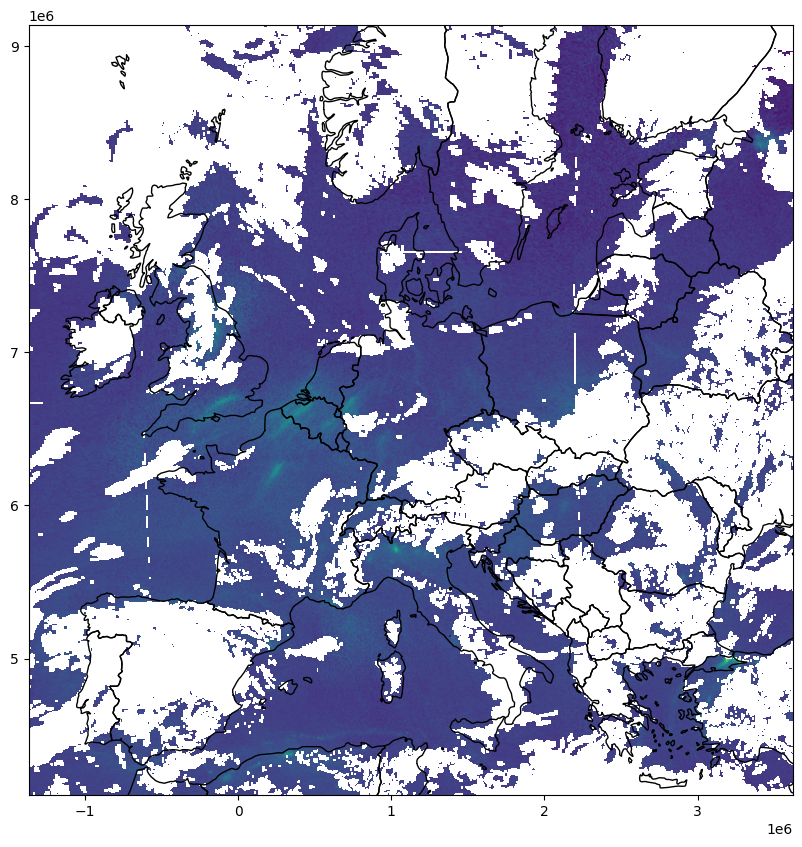

In [21]:
plot_request(request_raw, bbox_europe)

We can see here that even though the data is already mosaiced together, filling the entire bounding box, we do not have data everywhere since Tropomi does have a bunch of missing data per acquisition depending on atmospheric conditions. 

With this image we can already see some patterns but let's try to get a more representative image and take the mean of the NO2 values over an entire month to get a more complete picture.

To do this we do not have to download all of the data for an entire month, instead we can extend our evalscript so that the mean value for a month is calculated in the cloud for us. Doing it like this saves us a bunch of time downloading all images. So let's have a look at the updated evalscript:

The most important thing that changed is that we now changed the mosaicking input to ORBIT. This gives us all acquisitions for a time series to calculate values from. In the input we also have added `dataMask` as a band. This will tell us, if the NO2 band has data or not. We are using this to remove acquisitions without data from our calculation.

In our `evaluatePixel` function we have added two more steps. The first one is to filter out all acquisitions which do not have data with the `isClear()` function. After we have filtered the time series we can calculate the mean of all values using the `sum()` function and the length of the clear timeseries.

In the end we return the mean value we have calculated.

```js
//VERSION=3
function setup() {
    return {
        input: ["NO2", "dataMask"],
        output: {
            bands: 1,
            sampleType: "FLOAT32",
        },
        mosaicking: "ORBIT"
    };
}

function isClear(sample) {
    return sample.dataMask == 1;
}

function sum(array) {
    let sum = 0;
    for (let i = 0; i < array.length; i++) {
        sum += array[i].NO2;
    }
    return sum;
}

function evaluatePixel(samples) {
    const clearTs = samples.filter(isClear)
    const mean = sum(clearTs) / clearTs.length
    return [mean]
}
```

In [16]:
evalscript_mean_mosaic = """
//VERSION=3
function setup() {
    return {
        input: ["NO2", "dataMask"],
        output: {
            bands: 1,
            sampleType: "FLOAT32",
        },
        mosaicking: "ORBIT"
    };
}

function isClear(sample) {
    return sample.dataMask == 1;
}

function sum(array) {
    let sum = 0;
    for (let i = 0; i < array.length; i++) {
        sum += array[i].NO2;
    }
    return sum;
}

function evaluatePixel(samples) {
    const clearTs = samples.filter(isClear)
    const mean = sum(clearTs) / clearTs.length
    return [mean]
}
"""

In [17]:
request_monthly = SentinelHubRequest(
    evalscript=evalscript_mean_mosaic,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=data_5p,
            time_interval=("2022-12-01", "2023-01-01"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox_europe,
    resolution=(5000, 3500),
    config=config,
    data_folder="./data",
)

We now made a request for an entire month of data, for December of 2022. Other than that nothing much changed in the request.

In [18]:
mean_data = request_monthly.get_data(save_data=True)

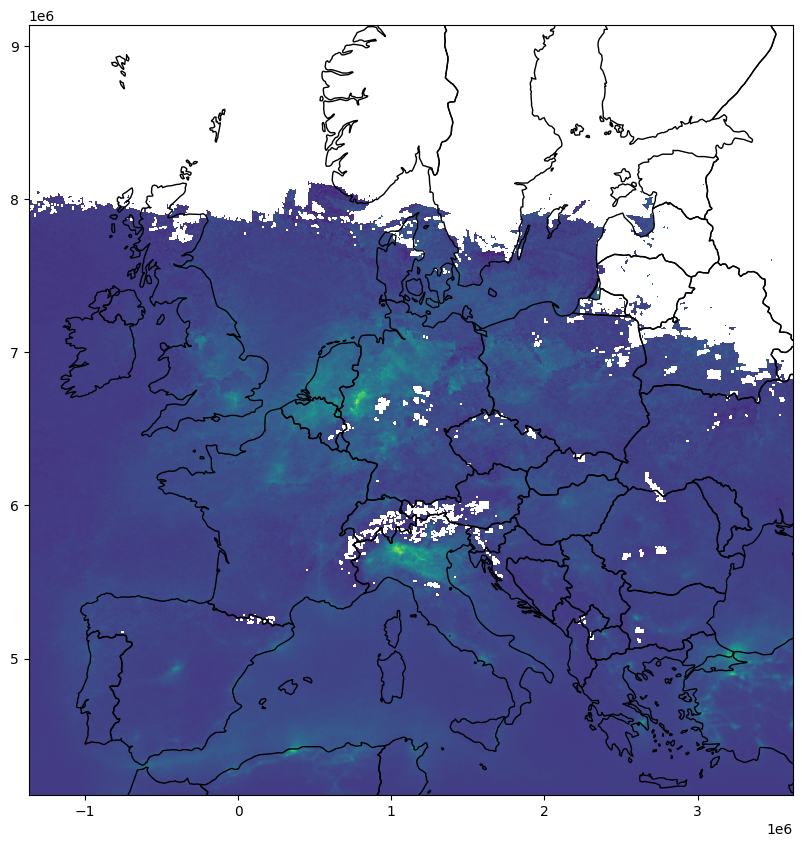

In [22]:
plot_request(request_monthly, bbox_europe)

This looks much better, since it is Winter the northern latitudes and the alps still do not have much data due to snow cover and low sun angles, however most of the rest of Europe is now covered by data.

We can clearly see NO2 hot spots around developed areas, like the Po Valley in Italy and the Ruhr area in Germany. You can also clearly make out the effect of some cities, like Istanbul and Madrid.

In general the distribution of values is around the lower end though. Only few pixels have much higher values.

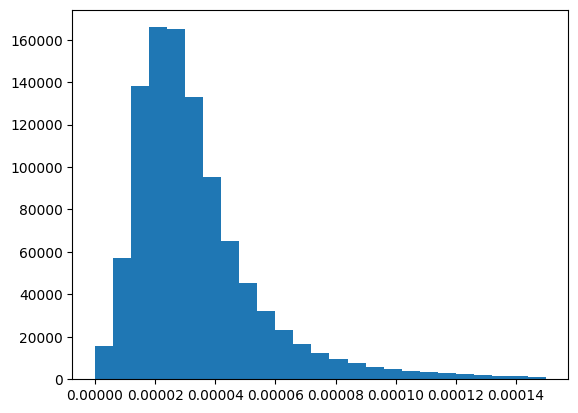

In [37]:
plt.stairs(*np.histogram(mean_data[0], range=(0, 0.00015), bins=25), fill=True);

### Analysing European countries

Now let's look at the distribution of values per country to see which countries had the highest average NO2 values in the month. 

To do this we rasterize all countries in our area of interest. We do this so that we can select all array values which are covered by a certain country.

In [122]:
countries["ID"] = countries.index

image_path = Path(request_monthly.data_folder) / request_monthly.get_filename_list()[0]
with rasterio.open(image_path) as src:
    affine = src.transform
# convert gpd Dataframe to format accepted by rasterize
geo_iter = list(countries[["geometry", "ID"]].itertuples(index=False, name=None))
# This call is converting the array into a raster with the same size as our NO2 raster
country_array = features.rasterize(
    geo_iter, transform=affine, out_shape=mean_data[0].shape, fill=-1
)

Now we define two helper functions which get all NO2 values in a country and another function which calcuates the mean of those values.

In [123]:
def get_array(country_id):
    return mean_data[0][country_array == country_id]


def get_mean(country_id):
    return np.nanmean(get_array(country_id))

This function is then applied to the countries dataframe, to fill a new column `mean` which holds the mean NO2 values per country.

In [124]:
countries["mean"] = countries.apply(lambda x: get_mean(x["ID"]), axis=1)

/tmp/ipykernel_5069/2776634825.py:5: RuntimeWarning: Mean of empty slice
  return np.nanmean(get_array(country_id))


We can then sort by that mean value and have a look at the countries with the highest mean.

In [125]:
sorted_df = countries.sort_values("mean", ascending=False)
sorted_df.head(10)

,ADMIN,geometry,ID,mean
20,Netherlands,"MULTIPOLYGON (((667242.940 6577267.510, 655945...",20,0.000108
48,Belgium,"POLYGON ((470455.301 6689943.442, 479173.878 6...",48,0.000099
40,Estonia,"MULTIPOLYGON (((3044805.494 7868837.787, 30419...",40,0.000077
36,Germany,"MULTIPOLYGON (((1060209.439 6028063.653, 10408...",36,0.000065
27,Luxembourg,"POLYGON ((680886.100 6467256.661, 679972.933 6...",27,0.000063
32,Italy,"MULTIPOLYGON (((781584.581 5768463.580, 785443...",32,0.000054
14,San Marino,"POLYGON ((1389852.107 5450198.738, 1383296.868...",14,0.000049
30,Latvia,"POLYGON ((2960380.966 7492512.846, 2954738.894...",30,0.000049
1,Jersey,"POLYGON ((-224715.351 6314191.162, -223742.393...",1,0.000047
24,Monaco,"POLYGON ((828069.165 5426902.987, 821285.634 5...",24,0.000047


For the 5 countries with the highest mean we are then plotting a boxplot of NO2 values. 

In [131]:
# get the country ids with the 5 highest mean values
n_countries = 5
country_ids = list(sorted_df["ID"][:n_countries])
country_names = list(sorted_df["ADMIN"][:n_countries])

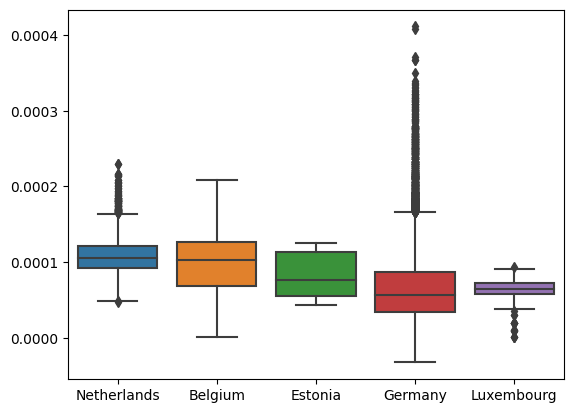

In [132]:
ax = sns.boxplot(data=[get_array(country_id) for country_id in country_ids])
ax.set_xticklabels(country_names);

From this we can see that even though the mean of values in Germany is the 4th lowest, of the 5 countries it has the absolute highest values. We can also see that Belgium and Germany both have qutie the large variance in NO2 values, with some areas of low NO2 concentration and some areas quite high concentrations.

### Analysing EU Capitals

Now we want to take a look at EU capitals specifically. For this more focused analysis we want to analyse time series data. To do this we are taking advantage of another API capability, the [Statistical API](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Statistical.html).

Even for the previous analysis of European countries, if we were not interested at all in the spatial distribution of data and only interested in statistics for certain geometries, the statistical API would have been the perfect fit. It removes the need to download a lot of data to calculate statistics for areas. Instead it does all of the calculation of statistics like mean, max, min and standard deviation in the cloud and in the end only sends those values. 

Another capability of the API is the easy chunking in regular intervals, which we will be using to make the time series.

But let's first import the EU capitals:

In [25]:
# load capitals
capitals = gpd.read_file("./data/eu_capitals.geojson")

The evalscript for the Statistical API is quite similar to the evalscript for the Processing API. However for the statistical API to work we need to add one more output named `dataMask`. This provides a binary mask for the API, telling it which pixels should be included in the statistical request.

Other than that not much changed compared to our previous request.

In [26]:
evalscript_stat = """
//VERSION=3
function setup() {
    return {
        input: ["NO2", "dataMask"],
        output: [{ 
          id: "default",
          bands: ["NO2"],
          sampleType: "FLOAT32" 
        },
        { 
          id: "dataMask",
          bands: 1,
        }],
        mosaicking: "ORBIT"
    };
}

function isClear(sample) {
    return sample.dataMask == 1;
}

function sum(array) {
    let sum = 0;
    for (let i = 0; i < array.length; i++) {
        sum += array[i].NO2;
    }
    return sum;
}

function evaluatePixel(samples) {
    const clearTs = samples.filter(isClear)
    const mean = sum(clearTs) / clearTs.length
    return {default: [mean], dataMask: [clearTs.length]}
}
"""

Now we define the Statistical API request, for that we first define an aggregation. Here we define the time range we are interesed in. In this case it is one year of data, all of 2022. We then define the aggregation interval, this defines how many days are aggregated. Since Sentinel 5P has a very high revisit rate we can define a temporal resolution of one day. However we could just as easily make a time series of weekly or monthly values just by changing the aggregation interval to `P1W` or `P1M` respectively.

The size is set to 1 by 1 pixel since Sentinel 5P pixels are quite large and we are only intersted in point data for the capitals.

In [184]:
aggregation = SentinelHubStatistical.aggregation(
    evalscript=evalscript_stat,
    time_interval=("2022-01-01", "2023-01-01"),
    aggregation_interval="P1D",
    size=(1, 1),
)

input_data = SentinelHubStatistical.input_data(
    DataCollection.SENTINEL5P.define_from("5p", service_url=config.sh_base_url)
)

requests = []

We then create one request for each capital city. Instead of doing it like this we could also use the Batch Statistical API which is designed to calculate statistics for many polygons efficiently. Batch Statistical API will also be available on the Copernicus Browser later in 2023.

This list of requests is then downloaded in parallel

In [185]:
for geo_shape in capitals.geometry.values:
    request = SentinelHubStatistical(
        aggregation=aggregation,
        input_data=[input_data],
        geometry=Geometry(geo_shape, crs=CRS(capitals.crs)),
        config=config,
    )
    requests.append(request)

download_requests = [request.download_list[0] for request in requests]
client = SentinelHubStatisticalDownloadClient(config=config)
pollution_stats = client.download(download_requests, max_threads=5, show_progress=True)

This is a helper function to convert the output of the statistical API to a pandas dataframe.

In [188]:
def stats_to_df(stats_data):
    """Transform Statistical API response into a pandas.DataFrame"""
    df_data = []

    for single_data in stats_data["data"]:
        df_entry = {}
        is_valid_entry = True

        df_entry["interval_from"] = parse_time(single_data["interval"]["from"]).date()
        df_entry["interval_to"] = parse_time(single_data["interval"]["to"]).date()

        for output_name, output_data in single_data["outputs"].items():
            for band_name, band_values in output_data["bands"].items():
                band_stats = band_values["stats"]
                if band_stats["sampleCount"] == band_stats["noDataCount"]:
                    is_valid_entry = False
                    break

                for stat_name, value in band_stats.items():
                    col_name = f"{output_name}_{band_name}_{stat_name}"
                    if stat_name == "percentiles":
                        for perc, perc_val in value.items():
                            perc_col_name = f"{col_name}_{perc}"
                            df_entry[perc_col_name] = perc_val
                    else:
                        df_entry[col_name] = value

        if is_valid_entry:
            df_data.append(df_entry)

    return pd.DataFrame(df_data)

Here we build the dataframe from the request output.

In [189]:
no2_dfs = [stats_to_df(polygon_stats) for polygon_stats in pollution_stats]

for df, capital in zip(no2_dfs, capitals["name"].values):
    df["name"] = capital

no2_df = pd.concat(no2_dfs)
no2_df["month"] = no2_df["interval_from"].astype("datetime64[ns]").dt.month
no2_df.to_csv("./data/no2_capitals_timeseries.csv")
no2_df

,interval_from,interval_to,default_NO2_min,default_NO2_max,default_NO2_mean,default_NO2_stDev,default_NO2_sampleCount,default_NO2_noDataCount,name
0,2022-03-22,2022-03-23,0.000047,0.000047,0.000047,0.0,1,0,Vilnius
1,2022-04-17,2022-04-18,0.000020,0.000020,0.000020,0.0,1,0,Vilnius
2,2022-04-18,2022-04-19,0.000018,0.000018,0.000018,0.0,1,0,Vilnius
3,2022-04-26,2022-04-27,0.000039,0.000039,0.000039,0.0,1,0,Vilnius
4,2022-04-27,2022-04-28,0.000035,0.000035,0.000035,0.0,1,0,Vilnius
...,...,...,...,...,...,...,...,...,...
170,2022-12-25,2022-12-26,0.000103,0.000103,0.000103,0.0,1,0,Vienna
171,2022-12-27,2022-12-28,0.000034,0.000034,0.000034,0.0,1,0,Vienna
172,2022-12-28,2022-12-29,0.000047,0.000047,0.000047,0.0,1,0,Vienna
173,2022-12-30,2022-12-31,0.000163,0.000163,0.000163,0.0,1,0,Vienna


With this dataframe we can now do analysis. To give an example we are looking at the time series for a few different capital cities.

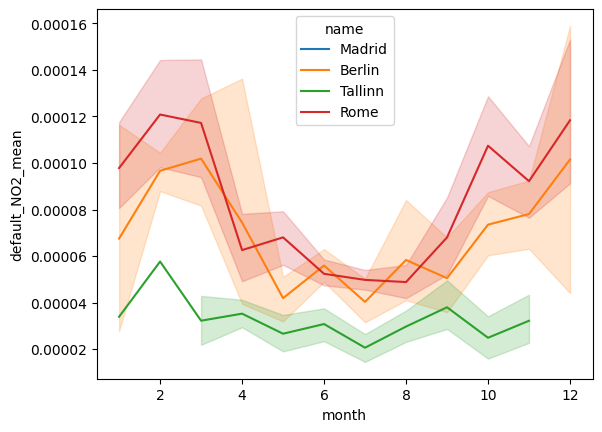

In [29]:
sel_capitals = ["Tallinn", "Berlin", "Rome", "Madrid"]
sns.lineplot(
    data=no2_df.loc[no2_df["name"].isin(sel_capitals)],
    x="month",
    y="default_NO2_mean",
    hue="name",
);

This shows us that for most cities the NO2 concentration is seasonal, with higher values in winter than in Summer. Madrid, Berlin and Rome all share quite similar temporal patterns. Tallinn on the other hand has much lower NO2 concentration throughout.

With this data now acquired many different types of analysis can be carried out. This showed the advantage of statistical API, since you don't have to download entire tiles even if you are only interested in the value of a single pixel. This makes data access much more efficient, allowing you to get started with analysis much quicker.